In [1]:
import torch
%matplotlib inline
from matplotlib import pyplot

import p2ch14.dsets
import p2ch14.model


In [2]:
ds = p2ch14.dsets.MalignantLunaDataset(val_stride=10, isValSet_bool=True)  # <1>
nodules = ds.ben_list + ds.mal_list
is_mal = torch.tensor([n.isMal_bool for n in nodules])  # <2>
diam  = torch.tensor([n.diameter_mm for n in nodules])
num_mal = is_mal.sum()  # <3>
num_ben = len(is_mal) - num_mal

2020-05-12 21:52:35,369 INFO     pid:7408 p2ch14.dsets:322:__init__ <p2ch14.dsets.MalignantLunaDataset object at 0x000001A6577B0C50>: 51583 validation samples, 51429 neg, 154 pos, unbalanced ratio


In [3]:
threshold = torch.linspace(diam.max(), diam.min())

In [4]:
predictions = (diam[None] >= threshold[:, None])  # <1>
tp_diam = (predictions & is_mal[None]).sum(1).float() / num_mal  # <2>
fp_diam = (predictions & ~is_mal[None]).sum(1).float() / num_ben

In [5]:
fp_diam_diff =  fp_diam[1:] - fp_diam[:-1]
tp_diam_avg  = (tp_diam[1:] + tp_diam[:-1])/2
auc_diam = (fp_diam_diff * tp_diam_avg).sum()

In [6]:
fp_fill = torch.ones((fp_diam.shape[0] + 1,))
fp_fill[:-1] = fp_diam

tp_fill = torch.zeros((tp_diam.shape[0] + 1,))
tp_fill[:-1] = tp_diam

print(threshold)
print(fp_diam)
print(tp_diam)

tensor([22.7815, 22.5843, 22.3870, 22.1898, 21.9925, 21.7953, 21.5980, 21.4008,
        21.2035, 21.0062, 20.8090, 20.6117, 20.4145, 20.2172, 20.0200, 19.8227,
        19.6255, 19.4282, 19.2310, 19.0337, 18.8365, 18.6392, 18.4420, 18.2447,
        18.0474, 17.8502, 17.6529, 17.4557, 17.2584, 17.0612, 16.8639, 16.6667,
        16.4694, 16.2722, 16.0749, 15.8777, 15.6804, 15.4832, 15.2859, 15.0886,
        14.8914, 14.6941, 14.4969, 14.2996, 14.1024, 13.9051, 13.7079, 13.5106,
        13.3134, 13.1161, 12.9189, 12.7216, 12.5244, 12.3271, 12.1298, 11.9326,
        11.7353, 11.5381, 11.3408, 11.1436, 10.9463, 10.7491, 10.5518, 10.3546,
        10.1573,  9.9601,  9.7628,  9.5656,  9.3683,  9.1710,  8.9738,  8.7765,
         8.5793,  8.3820,  8.1848,  7.9875,  7.7903,  7.5930,  7.3958,  7.1985,
         7.0013,  6.8040,  6.6068,  6.4095,  6.2122,  6.0150,  5.8177,  5.6205,
         5.4232,  5.2260,  5.0287,  4.8315,  4.6342,  4.4370,  4.2397,  4.0425,
         3.8452,  3.6479,  3.4507,  3.25

In [7]:
for i in range(threshold.shape[0]):
    print(i, threshold[i], fp_diam[i], tp_diam[i])

0 tensor(22.7815) tensor(0.) tensor(0.0192)
1 tensor(22.5843) tensor(0.) tensor(0.0192)
2 tensor(22.3870) tensor(0.) tensor(0.0192)
3 tensor(22.1898) tensor(0.) tensor(0.0192)
4 tensor(21.9925) tensor(0.) tensor(0.0192)
5 tensor(21.7953) tensor(0.) tensor(0.0192)
6 tensor(21.5980) tensor(0.) tensor(0.0192)
7 tensor(21.4008) tensor(0.) tensor(0.0192)
8 tensor(21.2035) tensor(0.) tensor(0.0192)
9 tensor(21.0062) tensor(0.) tensor(0.0385)
10 tensor(20.8090) tensor(0.) tensor(0.0385)
11 tensor(20.6117) tensor(0.) tensor(0.0385)
12 tensor(20.4145) tensor(0.) tensor(0.0385)
13 tensor(20.2172) tensor(0.) tensor(0.0385)
14 tensor(20.0200) tensor(0.) tensor(0.0385)
15 tensor(19.8227) tensor(0.) tensor(0.0385)
16 tensor(19.6255) tensor(0.) tensor(0.0577)
17 tensor(19.4282) tensor(0.) tensor(0.0577)
18 tensor(19.2310) tensor(0.) tensor(0.0577)
19 tensor(19.0337) tensor(0.) tensor(0.0577)
20 tensor(18.8365) tensor(0.) tensor(0.0577)
21 tensor(18.6392) tensor(0.) tensor(0.0769)
22 tensor(18.4420) t

diam: 10.55, x: 0.01, y: 0.56
diam: 5.42, x: 0.43, y: 0.96


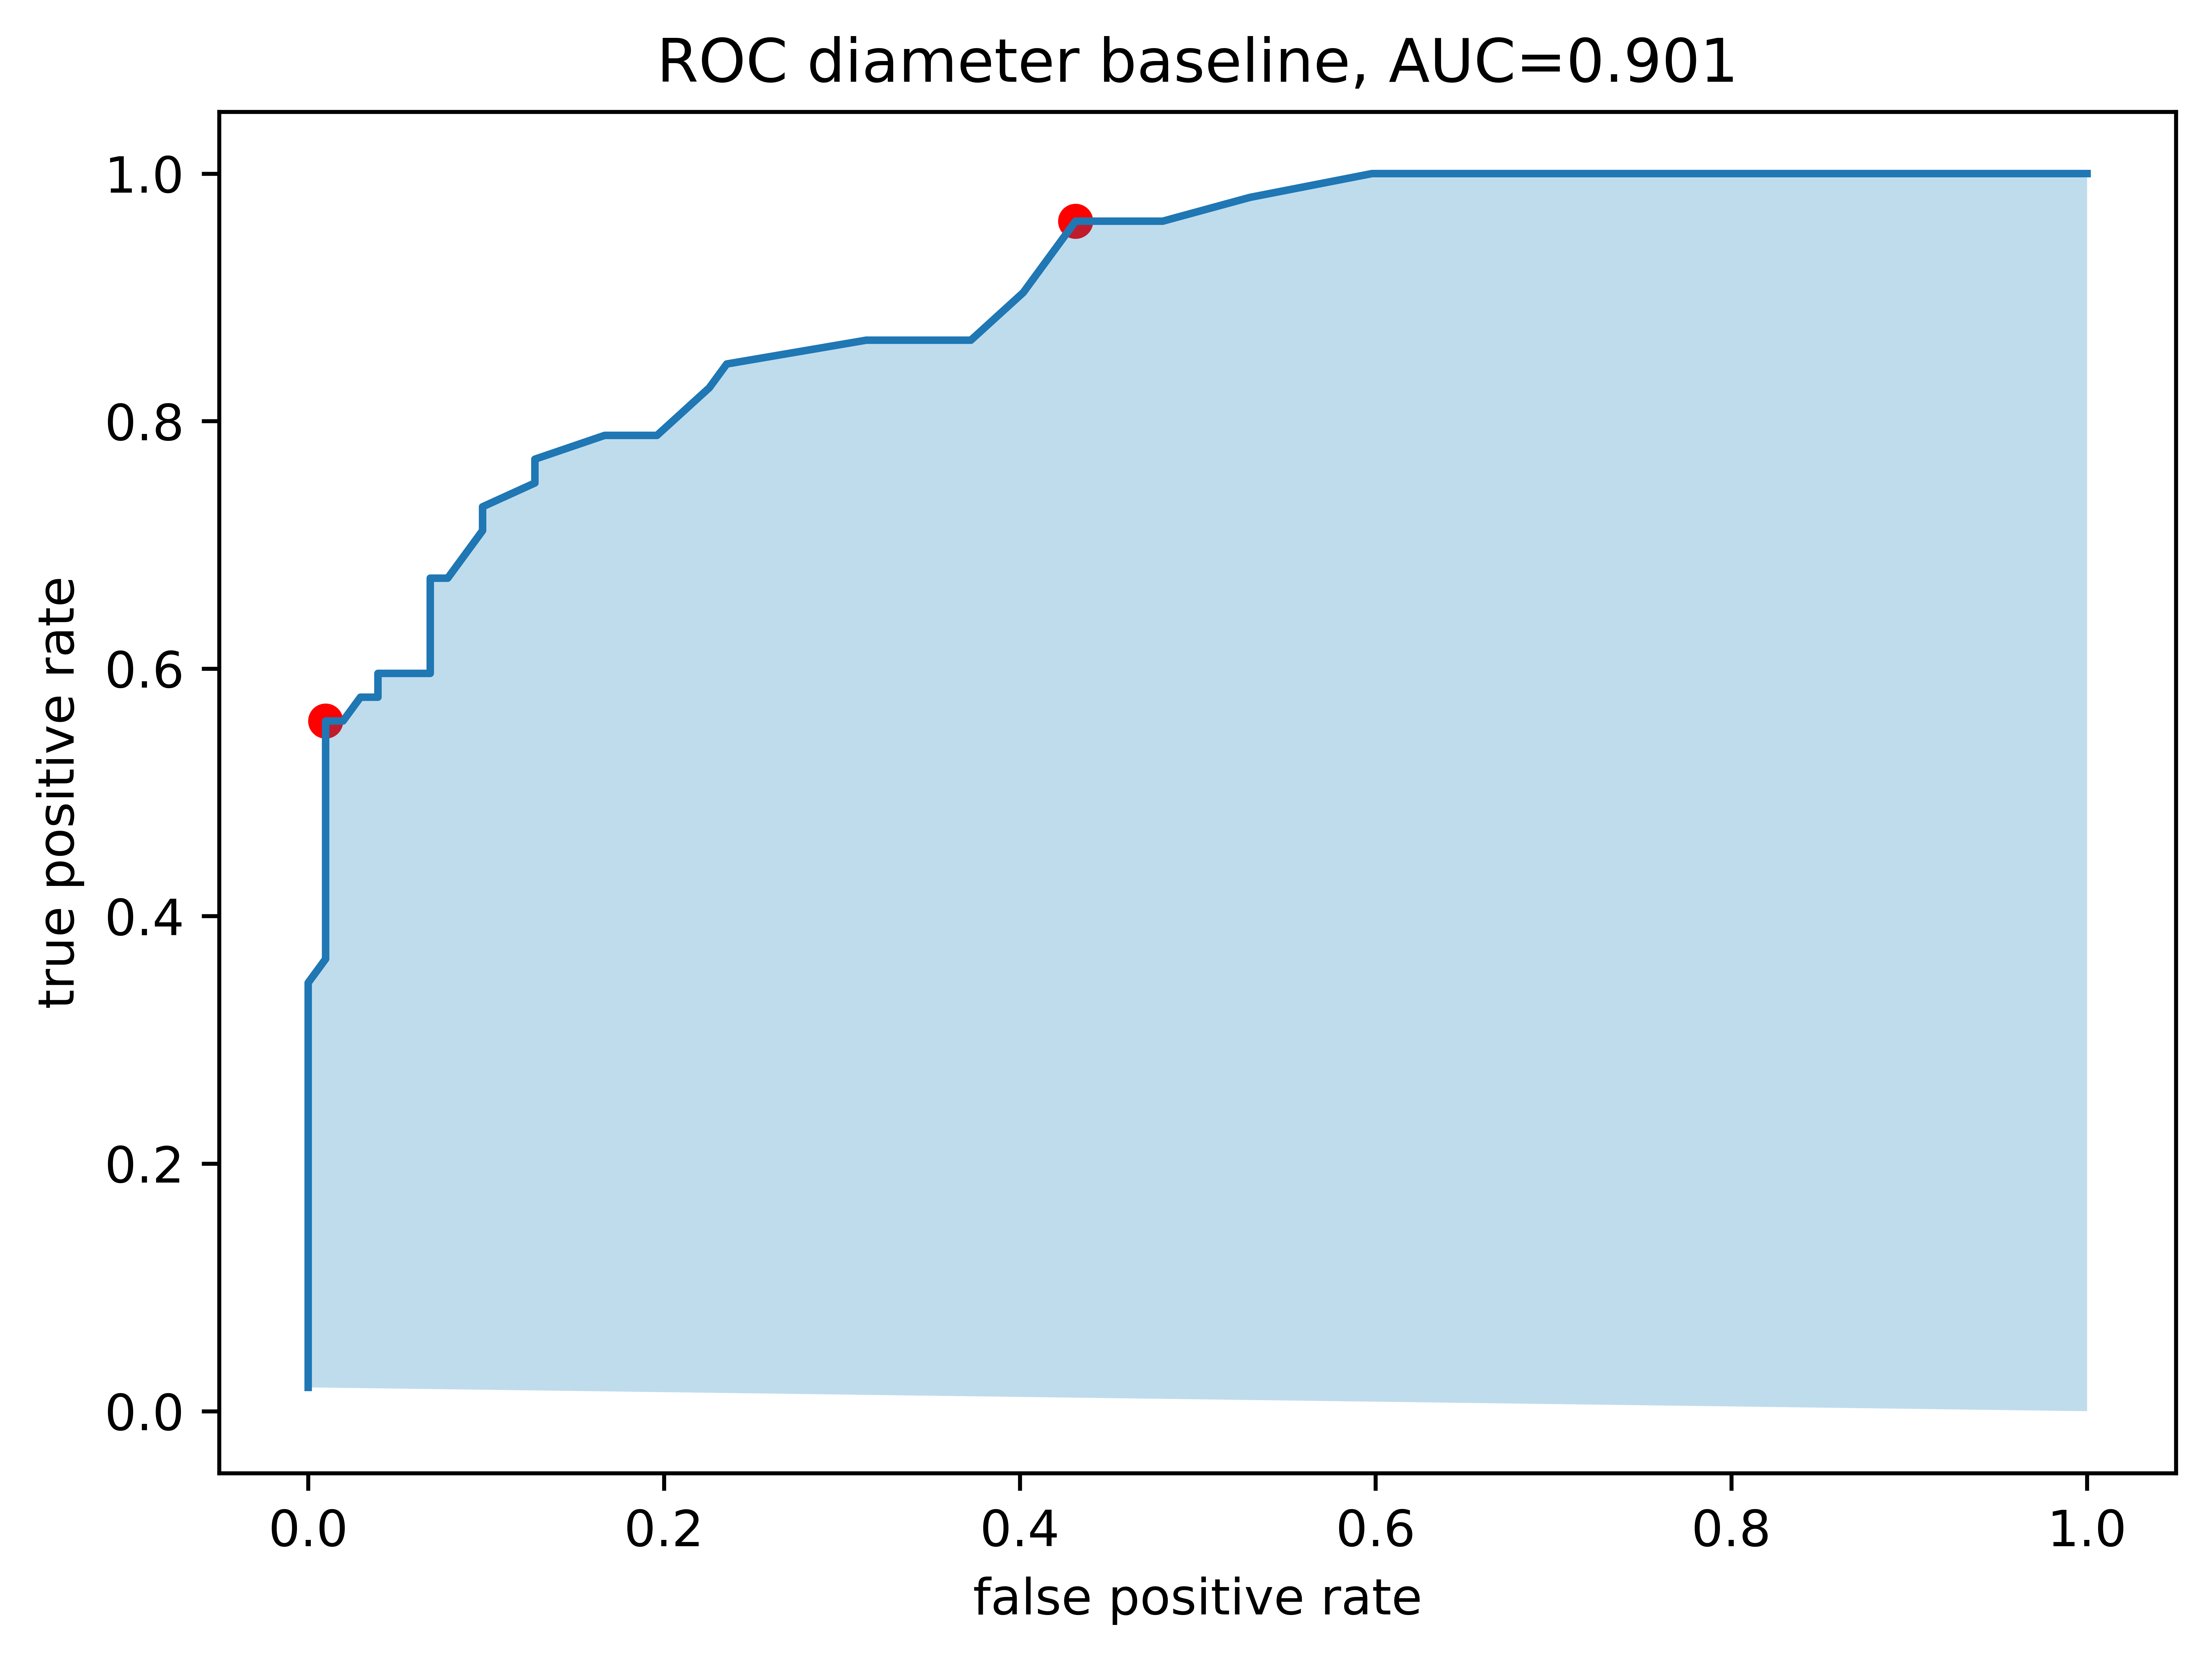

In [8]:
pyplot.figure(figsize=(7,5), dpi=1200)
for i in [62, 88]:
    pyplot.scatter(fp_diam[i], tp_diam[i], color='red')
    print(f'diam: {round(threshold[i].item(), 2)}, x: {round(fp_diam[i].item(), 2)}, y: {round(tp_diam[i].item(), 2)}')
pyplot.fill(fp_fill, tp_fill, facecolor='#0077bb', alpha=0.25)
pyplot.plot(fp_diam, tp_diam, label=f'diameter baseline, AUC={auc_diam:.3f}')
pyplot.title(f'ROC diameter baseline, AUC={auc_diam:.3f}')
pyplot.ylabel('true positive rate')
pyplot.xlabel('false positive rate')
pyplot.savefig('roc_diameter_baseline.png')

In [9]:
model = p2ch14.model.LunaModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sd = torch.load('data/part2/models/cls_2020-02-08_01.19.40_finetune-head.best.state')
model.load_state_dict(sd['model_state'])
model.to(device)
model.eval();

In [10]:
ds = p2ch14.dsets.MalignantLunaDataset(val_stride=10, isValSet_bool=True)
dl = torch.utils.data.DataLoader(ds, batch_size=32, num_workers=4)


2020-05-12 21:52:45,027 INFO     pid:7408 p2ch14.dsets:322:__init__ <p2ch14.dsets.MalignantLunaDataset object at 0x000001A65D9D96A0>: 51583 validation samples, 51429 neg, 154 pos, unbalanced ratio


In [11]:
preds = []
truth = []
for inp, label, _, _, _ in dl:
    inp = inp.to(device)    
    truth += (label[:,1]>0).tolist()
    with torch.no_grad():
        _, p = model(inp)
        preds += p[:, 1].tolist()
truth = torch.tensor(truth)
preds = torch.tensor(preds)

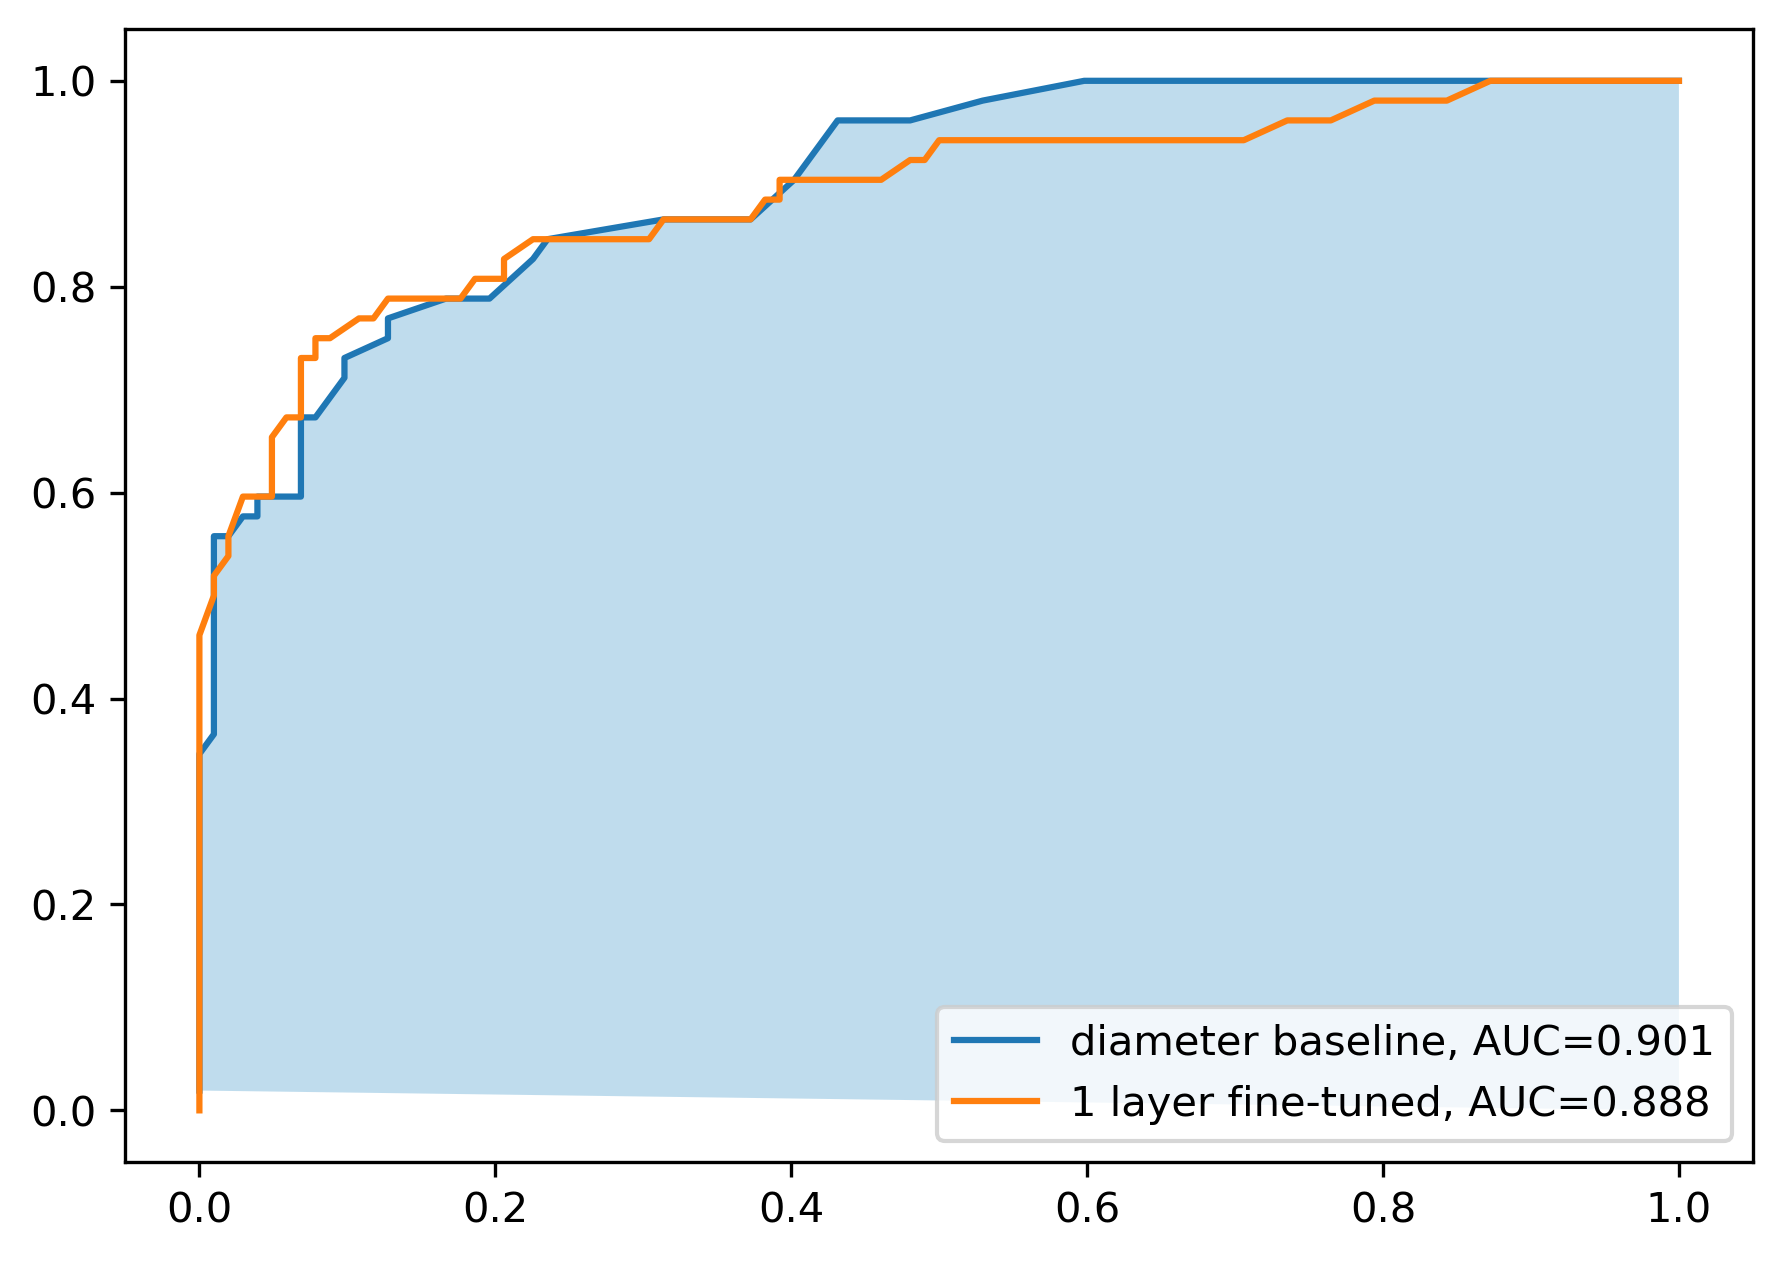

In [12]:
num_mal = truth.sum()
num_ben = len(truth) - num_mal
threshold = torch.linspace(1, 0)
tp_finetune = ((preds[None] >= threshold[:, None]) & truth[None]).sum(1).float() / num_mal
fp_finetune = ((preds[None] >= threshold[:, None]) & ~truth[None]).sum(1).float() / num_ben
fp_finetune_diff = fp_finetune[1:]-fp_finetune[:-1]
tp_finetune_avg  = (tp_finetune[1:]+tp_finetune[:-1])/2
auc_finetune = (fp_finetune_diff * tp_finetune_avg).sum()

pyplot.figure(figsize=(7,5), dpi=300)
pyplot.fill(fp_fill, tp_fill, facecolor='#0077bb', alpha=0.25)
pyplot.plot(fp_diam, tp_diam, label=f'diameter baseline, AUC={auc_diam:.3f}')
pyplot.plot(fp_finetune, tp_finetune, label=f'1 layer fine-tuned, AUC={auc_finetune:.3f}')
pyplot.legend()
pyplot.savefig('roc_finetune.png')

In [13]:
if 1:
    fn = 'data/part2/models/cls_2020-02-08_00.19.45_finetune-depth2.best.state'
    model = p2ch14.model.LunaModel()
    sd = torch.load(fn, map_location='cpu')['model_state']
    model.load_state_dict(sd)
    model.to(device)
    model.eval();


In [14]:
model.eval()
preds = []
truth = []
for inp, label, _, _, _ in dl:
    inp = inp.to(device)    
    truth += (label[:,1]>0).tolist()
    with torch.no_grad():
        _, p = model(inp)
        preds += p[:, 1].tolist()
truth = torch.tensor(truth)
preds = torch.tensor(preds)

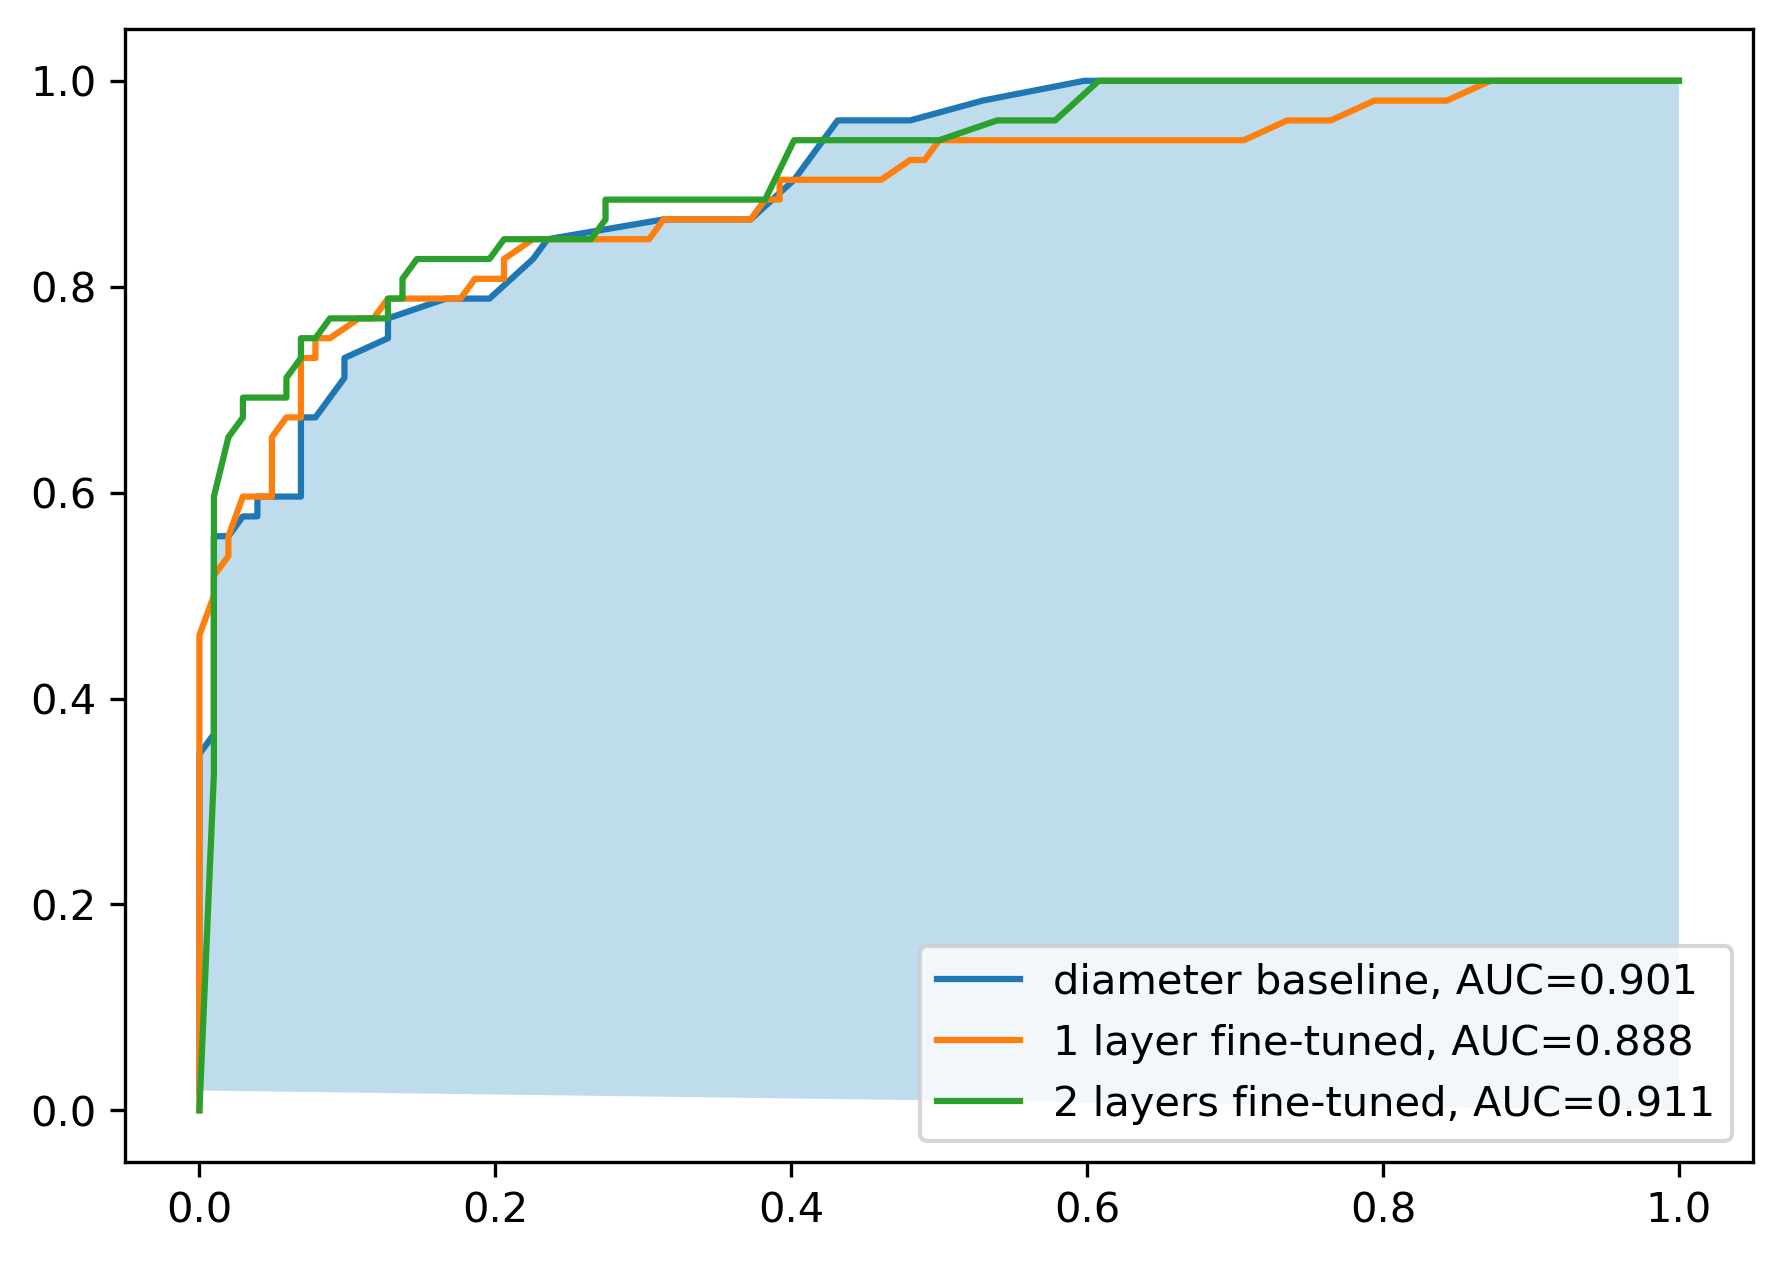

In [15]:
num_mal = truth.sum()
num_ben = len(truth) - num_mal
threshold = torch.linspace(1, 0)
tp = ((preds[None] >= threshold[:, None]) & truth[None]).sum(1).float() / num_mal
fp = ((preds[None] >= threshold[:, None]) & ~truth[None]).sum(1).float() / num_ben

fp_diff = fp[1:]-fp[:-1]
tp_avg  = (tp[1:]+tp[:-1])/2
auc_modified = (fp_diff * tp_avg).sum()

pyplot.figure(figsize=(7,5), dpi=300)
pyplot.fill(fp_fill, tp_fill, facecolor='#0077bb', alpha=0.25)
pyplot.plot(fp_diam, tp_diam, label=f'diameter baseline, AUC={auc_diam:.3f}')
pyplot.plot(fp_finetune, tp_finetune, label=f'1 layer fine-tuned, AUC={auc_finetune:.3f}')
pyplot.plot(fp, tp, label=f'2 layers fine-tuned, AUC={auc_modified:.3f}')
pyplot.legend()
pyplot.savefig('roc_modified.png')